<a href="https://colab.research.google.com/github/Vadiman728/segmentation-of-human-lungs-on-U-Net-duble-plus/blob/main/%D0%A1%D0%B5%D0%B3%D0%BC%D0%B5%D0%BD%D1%82%D0%B0%D1%86%D0%B8%D1%8F_%D0%BB%D0%B5%D0%B3%D0%BA%D0%B8%D1%85_%D1%87%D0%B5%D0%BB%D0%BE%D0%B2%D0%B5%D0%BA%D0%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Импорт библиотек

In [ ]:
!pip install concatenate

In [ ]:
from concatenate import concatenate
import tensorflow as tf                                                               # библиотека Tensorflow
import keras                                                                          # библиотека Keras
from keras.layers import Input, Conv2D, MaxPooling2D, Activation, ReLU, Rescaling     # cлои библиотеки Keras
from keras.layers import BatchNormalization, Conv2DTranspose, Concatenate             # cлои библиотеки Keras
from keras.layers import Rescaling, Resizing, Dropout                                          # cлои библиотеки Keras
from keras.models import Model, Sequential                                            # конструкторы построения моделей библиотеки Keras

from keras.optimizers import Adam                                                     # оптимизатор Adam
from keras.preprocessing.image import  load_img                                       # загрузка изображений
from keras.utils import to_categorical                                                # преобразует вектор класса (целые числа) в двоичную матрицу класса

import random                                                                         # генератор случайных чисел

import numpy as np                                                                    # библиотека линейной алгебры
import pandas as pd                                                                   # библиотека обработки табличных данных
import os                                                                             # библиотека работы с функциями операционной системы, в том числе с файлами
import albumentations as A                                                            # библиотека аугментации изображений (https://albumentations.ai/)
import matplotlib.pyplot as plt                                                       # библиотека для рисования графиков
%matplotlib inline

# Загрузка датасета

In [ ]:
!pip install opendatasets

In [ ]:
import opendatasets as op
op.download("https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database/")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: vadimmanin
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database


100%|██████████| 778M/778M [00:08<00:00, 95.4MB/s]


In [ ]:
import skimage.io                           #Used for imshow function
import skimage.transform                    #Used for resize function
from skimage.morphology import label        #Used for Run-Length-Encoding RLE to create final submission
import glob

IMG_WIDTH       = 160
IMG_HEIGHT      = 160
IMG_CHANNELS    = 1

image_path = '/content/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/images'
mask_path = '/content/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/masks'


# Пути к файлам изображений и меткам (если они есть)
def get_img_data(path, output_shape=(None,None)):
    image_paths = ['{0}/{1}'.format(path, img_id) for img_id in os.listdir(path)]
    img_data = []

    for img_path in image_paths:
        img = skimage.io.imread(img_path)

        if img.ndim == 3:  # Если изображение 3D (например, RGB или RGBA)
            if img.shape[2] == 4:  # Проверяем наличие альфа-канала
                img = img[:, :, 3]  # Берем только альфа-канал
            else:
                img = img[:, :, 0]  # Используем первый канал для RGB
        else:
            img = img  # Для 2D изображений просто используем их как есть

        resized_img = skimage.transform.resize(img, output_shape=output_shape, mode='constant', preserve_range=True)
        img_data.append(resized_img)

    return np.array(img_data, dtype=np.float32)
def get_mask_data(path, output_shape=(None, None)):

    image_paths = ['{0}/{1}'.format(path, img_id) for img_id in os.listdir(path)]
    mask_data = []
    for i, img_masks in enumerate(image_paths):  #loop through each individual nuclei for an image and combine them together
        masks = skimage.io.imread_collection(img_masks).concatenate()  #masks.shape = (num_masks, img_height, img_width)
        mask = np.max(masks, axis=0)                                   #mask.shape = (img_height, img_width)
        mask = skimage.transform.resize(mask, output_shape=output_shape+(1,), mode='constant', preserve_range=True)  #need to add an extra dimension so mask.shape = (img_height, img_width, 1)
        mask_data.append(mask)
    mask_data = np.array(mask_data, dtype=np.bool_)
    return mask_data


In [ ]:
img_data = get_img_data(image_path, output_shape=(IMG_HEIGHT, IMG_WIDTH))

In [ ]:
mask_data = get_mask_data(mask_path, output_shape=(IMG_HEIGHT, IMG_WIDTH) )

Удивительно, даже вместились в оперативную память

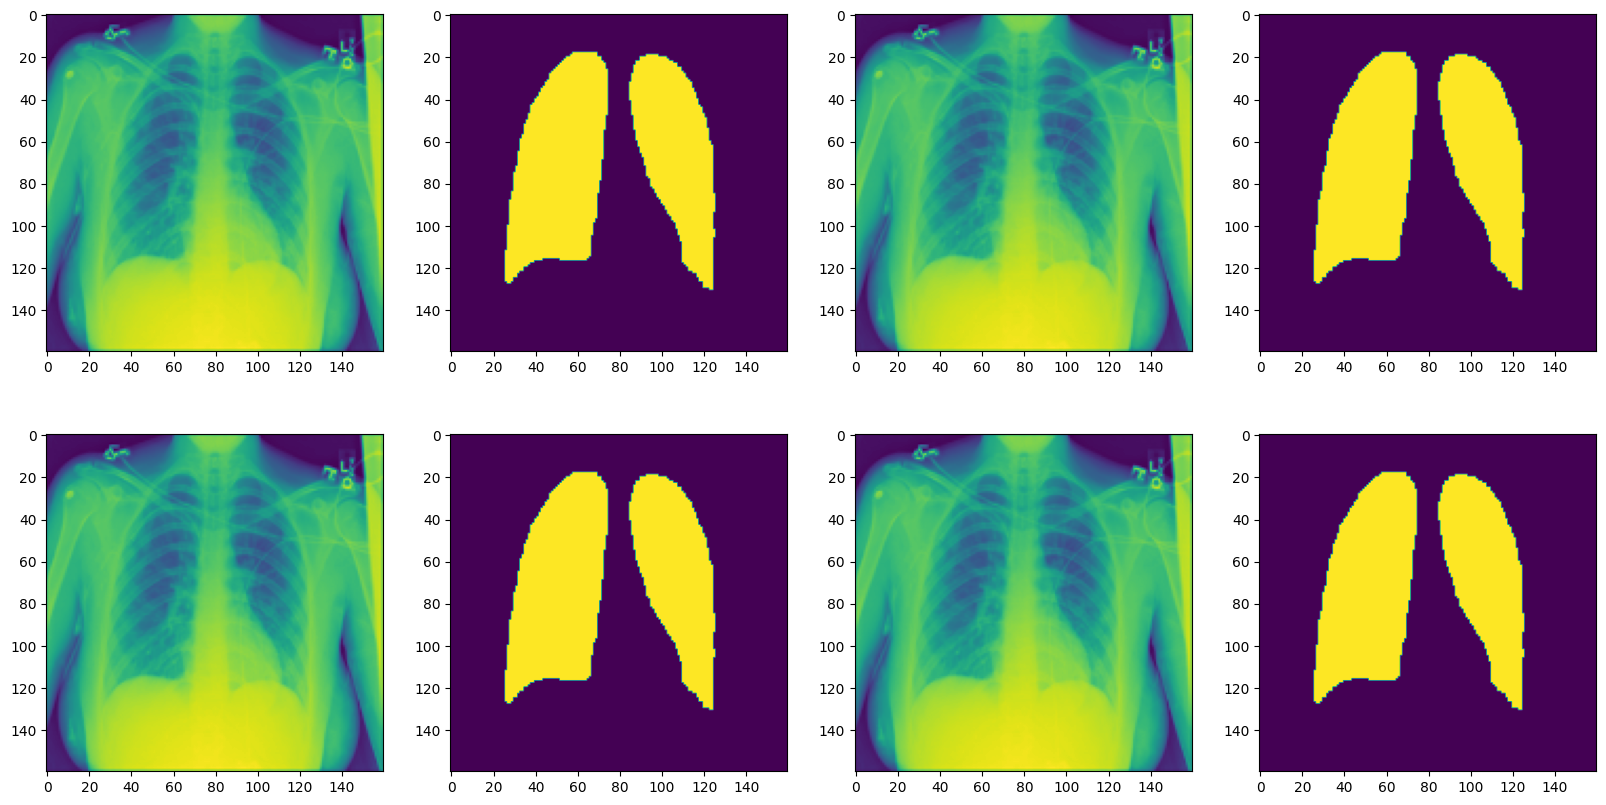

In [ ]:
train_ids = next(os.walk(image_path)) #собираем индексы

f, axarr = plt.subplots(2,4) #настраиваем полотно
f.set_size_inches(20,10)
ix = random.randint(0, len(train_ids[1])) # берем рандомный индкес
# берем 4 пары изображение-маска
axarr[0,0].imshow(img_data[ix])
axarr[0,1].imshow(np.squeeze(mask_data[ix]))

axarr[0,2].imshow(img_data[ix])
axarr[0,3].imshow(np.squeeze(mask_data[ix]))

axarr[1,0].imshow(img_data[ix])
axarr[1,1].imshow(np.squeeze(mask_data[ix]))

axarr[1,2].imshow(img_data[ix])
axarr[1,3].imshow(np.squeeze(mask_data[ix]))

plt.show()

In [ ]:
type(img_data)

numpy.ndarray

In [ ]:
from sklearn.model_selection import train_test_split

x_img, y_img, x_mask, y_mask = train_test_split(img_data, mask_data, train_size = 0.8, random_state=42, shuffle=False)

In [ ]:
img_data, mask_data = None, None

In [ ]:
print(x_img.shape)
print(y_img.shape)
print(x_mask.shape)
print(y_mask.shape)

(8153, 160, 160)
(2039, 160, 160)
(8153, 160, 160, 1)
(2039, 160, 160, 1)


In [ ]:
x_img = np.expand_dims(x_img, axis=-1)  # (8153, 160, 160) -> (8153, 160, 160, 1)
y_img = np.expand_dims(y_img, axis=-1)

In [ ]:
print(x_img.shape)
print(y_img.shape)
print(x_mask.shape)
print(y_mask.shape)

(8153, 160, 160, 1)
(2039, 160, 160, 1)
(8153, 160, 160, 1)
(2039, 160, 160, 1)


# Импортируем архитектуру

Возьмем архитектуру попроще, так как у нас задача бинарной классификации (ЧБ изображения)

In [ ]:
from tensorflow.keras import layers, Model, Input

def unetplusplus(input_shape=(IMG_HEIGHT, IMG_WIDTH,1), num_classes=1):
    inputs = Input(input_shape)

    # Секция закодирования
    def conv_block(x, filters):
        x = layers.Conv2D(filters, (3, 3), padding='same', activation='relu')(x)
        x = layers.Conv2D(filters, (3, 3), padding='same', activation='relu')(x)
        return x

    def upsample_block(x, filters):
        x = layers.UpSampling2D((2, 2))(x)
        x = layers.Conv2D(filters, (2, 2), padding='same', activation='relu')(x)
        return x

    # Этапы кодирования с пропускными соединениями (Encoder)
    e1 = conv_block(inputs, 64)
    p1 = layers.MaxPooling2D((2, 2))(e1)

    e2 = conv_block(p1, 128)
    p2 = layers.MaxPooling2D((2, 2))(e2)

    e3 = conv_block(p2, 256)
    p3 = layers.MaxPooling2D((2, 2))(e3)

    e4 = conv_block(p3, 512)
    p4 = layers.MaxPooling2D((2, 2))(e4)

    # Боттлнек
    bn = conv_block(p4, 1024)

    # Этап декодирования (Decoder) с дополнительными соединениями (nested skip connections)
    d4 = upsample_block(bn, 512)
    d4 = layers.Concatenate()([d4, e4])
    d4 = conv_block(d4, 512)

    d3 = upsample_block(d4, 256)
    d3 = layers.Concatenate()([d3, e3])
    d3 = conv_block(d3, 256)

    d2 = upsample_block(d3, 128)
    d2 = layers.Concatenate()([d2, e2])
    d2 = conv_block(d2, 128)

    d1 = upsample_block(d2, 64)
    d1 = layers.Concatenate()([d1, e1])
    d1 = conv_block(d1, 64)

    # Выходной слой
    outputs = layers.Conv2D(num_classes, (1, 1), padding='same', activation='sigmoid')(d1)

    return Model(inputs, outputs)

# Инициализация модели
model = unetplusplus(input_shape=(160, 160, 1), num_classes=1)
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 160, 160, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 160, 160, 64)   │            640 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 160, 160, 64)   │         36,928 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 80, 80, 64)     │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 80, 80, 128)    │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 80, 80, 128)    │        147,584 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 40, 40, 128)    │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 40, 40, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 40, 40, 256)    │        590,080 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 20, 20, 256)    │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 20, 20, 512)    │      1,180,160 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 20, 20, 512)    │      2,359,808 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 10, 10, 512)    │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 10, 10, 1024)   │      4,719,616 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 10, 10, 1024)   │      9,438,208 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d             │ (None, 20, 20, 1024)   │              0 │ conv2d_9[0][0]         │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_10 (Conv2D)        │ (None, 20, 20, 512)    │      2,097,664 │ up_sampling2d[0][0]    │
├──────────────────────

 Total params: 31,030,593 (118.37 MB)

 Trainable params: 31,030,593 (118.37 MB)

 Non-trainable params: 0 (0.00 B)

# Обучаем модель

Создадим коллбэк, чтобы зря не расходовать ресурсы граф процессора, скомпилируем модель с бинарной функцией потери. Ну и проверим наличие граф процессора, вдруг нет его

In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

# Убедимся, что используется GPU
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
else:
    print(f'Found GPU at: {device_name}')

model = unetplusplus(input_shape=(160, 160, 1), num_classes=1)

# Компиляция модели
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Создание коллбэка для ранней остановки
early_stopping = EarlyStopping(
    monitor='accuracy',  # отслеживание точности
    patience=3,          # количество эпох без улучшений, после которых остановится обучение
    min_delta=0.02,      # минимум улучшения точности на 2%
    mode='max',          # максимизация точности
    verbose=1
)

# Параметры обучения
epochs = 50
batch_size = 32

# Запуск обучения
history = model.fit(
    x_img, x_mask,
    validation_split=0.2,          # используется 20% данных для валидации
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[early_stopping],    # включаем раннюю остановку
    verbose=1
)

Found GPU at: /device:GPU:0
Epoch 1/50
204/204 ━━━━━━━━━━━━━━━━━━━━ 380s 1s/step - accuracy: 0.7644 - loss: 3.2235 - val_accuracy: 0.9826 - val_loss: 0.0446
Epoch 2/50
204/204 ━━━━━━━━━━━━━━━━━━━━ 187s 870ms/step - accuracy: 0.9843 - loss: 0.0402 - val_accuracy: 0.9699 - val_loss: 0.0761
Epoch 3/50
204/204 ━━━━━━━━━━━━━━━━━━━━ 201s 867ms/step - accuracy: 0.9846 - loss: 0.0402 - val_accuracy: 0.9907 - val_loss: 0.0232
Epoch 4/50
204/204 ━━━━━━━━━━━━━━━━━━━━ 192s 817ms/step - accuracy: 0.9909 - loss: 0.0226 - val_accuracy: 0.9922 - val_loss: 0.0192
Epoch 5/50
204/204 ━━━━━━━━━━━━━━━━━━━━ 169s 829ms/step - accuracy: 0.9924 - loss: 0.0181 - val_accuracy: 0.9925 - val_loss: 0.0182
Epoch 6/50
204/204 ━━━━━━━━━━━━━━━━━━━━ 211s 871ms/step - accuracy: 0.9931 - loss: 0.0164 - val_accuracy: 0.9914 - val_loss: 0.0206
Epoch 7/50
204/204 ━━━━━━━━━━━━━━━━━━━━ 191s 818ms/step - accuracy: 0.9933 - loss: 0.0160 - val_accuracy: 0.9927 - val_loss: 0.0181
Epoch 7: early stopping


# Оценка модели

64/64 ━━━━━━━━━━━━━━━━━━━━ 34s 523ms/step


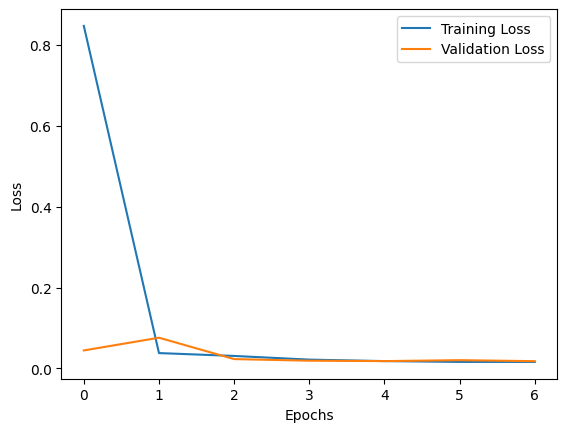

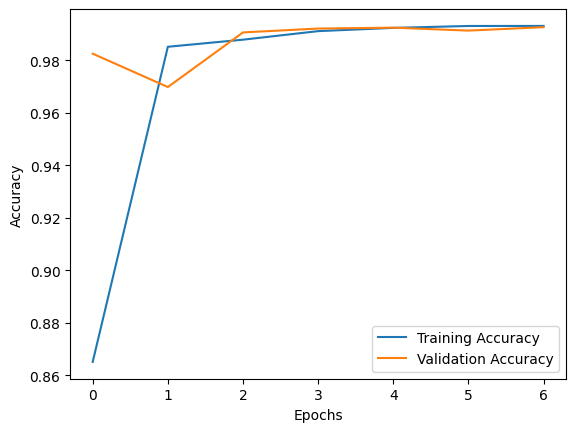

In [ ]:
# Запуск предсказания модели на тестовых данных
predictions = model.predict(y_img)

# Отображение результатов обучения
import matplotlib.pyplot as plt

# График потерь
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# График точности
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Обучение модели было остановлено колбэком, точность и так выше 98 процентов, куда больше. Тем самым не допустили переобучения и сэкономили ресурсы

Посмотрим, действительно ли модель справилась с заданием

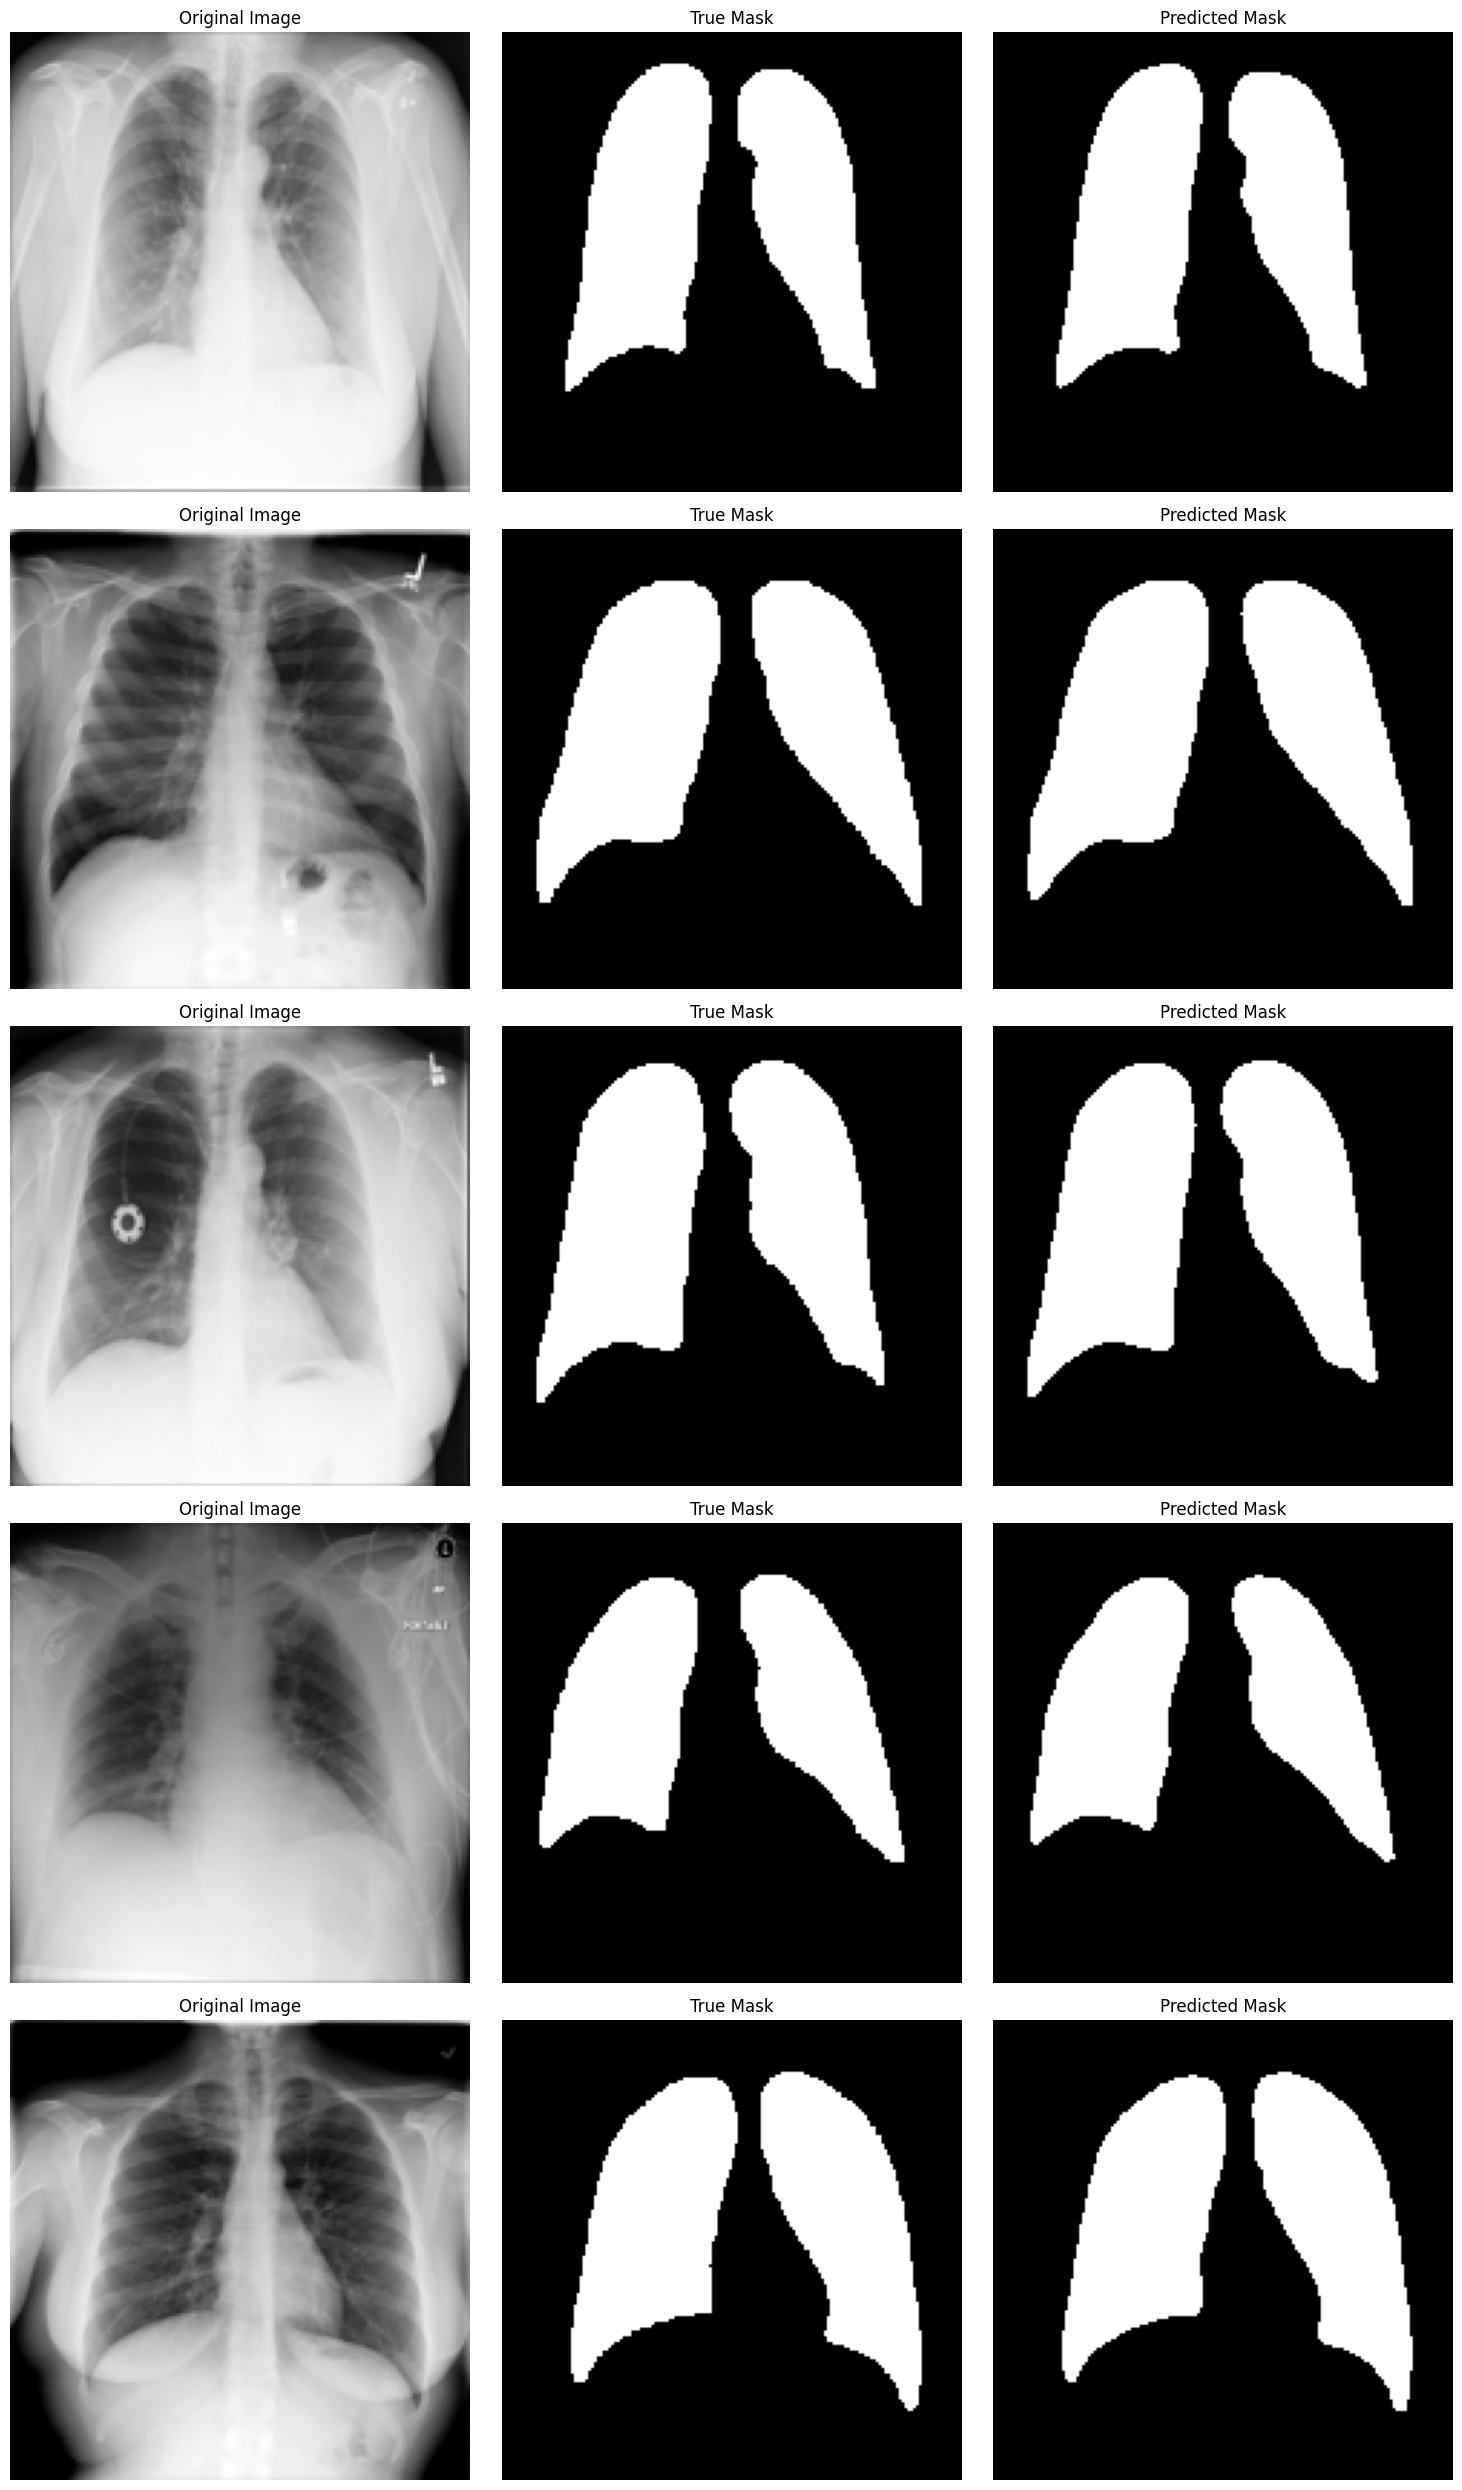

In [ ]:
threshold = 0.5
predicted_masks = (predictions > threshold).astype(np.uint8)

# Количество изображений для отображения
num_images = 5

plt.figure(figsize=(15, num_images * 5))
for i in range(num_images):
    # Оригинальное изображение
    plt.subplot(num_images, 3, i * 3 + 1)
    plt.imshow(y_img[i].squeeze(), cmap='gray')
    plt.title("Original Image")
    plt.axis("off")

    # Истинная маска
    plt.subplot(num_images, 3, i * 3 + 2)
    plt.imshow(y_mask[i].squeeze(), cmap='gray')
    plt.title("True Mask")
    plt.axis("off")

    # Предсказанная маска
    plt.subplot(num_images, 3, i * 3 + 3)
    plt.imshow(predicted_masks[i].squeeze(), cmap='gray')
    plt.title("Predicted Mask")
    plt.axis("off")

plt.tight_layout()
plt.show()

Я считаю, что даже очень справилась... Надо бы залить это задание на каггл для баллов...